###  The code in this notebook can be used to replicate:
    1. Figure 3
    2. Extended Data Figure 3 i-n
    3. Supplemental Figures 6, 8



#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/1fz9QbWfl5JxM6HdYedPqg4sc5_K4yx7j?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 

    1. "Supplemental_Data_2.SAAP_proteins.xlsx"
    2. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    3. "Supplemental_Data_4.SAAP_reporter_quant.xlsx"  
    4. Other files in https://drive.google.com/drive/folders/15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb?usp=sharing 


*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript.

In [36]:
# read in packages needed

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
#import milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Setting directories and reading in data.

All of these directories should be updated by the user to reflect where their output data from the decode pipeline st stored.


In [2]:
proj_dir = os.getcwd()+'/'
dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

# [dataset]_aa_subs_dir is the decode pipeline output folder
ccrcc_proj_dir = dependencies_dir+'CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = dependencies_dir+'UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = dependencies_dir+'BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = dependencies_dir+'LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = dependencies_dir+'PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = dependencies_dir+'LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = dependencies_dir+'HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]


In [3]:
class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

### Figure 3: RAAS as a function of synthesis and degradation 

#### Incl. Extended Data Figure 3i-n, Supplemental Fig. 8

In [5]:
filt_saap_df = pd.read_excel(dependencies_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)
filt_prec_quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
filt_reporter_quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_4.SAAP_reporter_quant.xlsx', index_col=0)

In [6]:
# custom colormap
# this colormap is used for all RAAS dotplots 

import matplotlib
from matplotlib.cm import get_cmap
inferno_cmap = get_cmap('inferno')
viridis_cmap = get_cmap('viridis')

inferno_colors = inferno_cmap.colors
viridis_colors = viridis_cmap.colors

inferno_colors[-1] = viridis_colors[-1]
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", inferno_colors)

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/450589004.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  inferno_cmap = get_cmap('inferno')
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/450589004.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cmap = get_cmap('viridis')


### Figure 3a and extended data figure 3i: codon mismatch

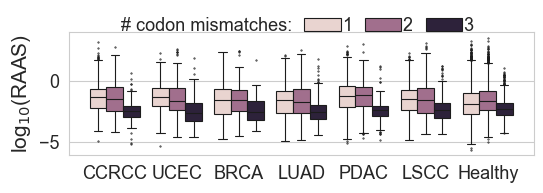

In [19]:
plot_df = pd.read_excel(dependencies_dir+'Codon_change_df.xlsx', index_col=0)
# plot for all dataset separately (extended 3i)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(6,1.6))
sns.boxplot(data=plot_df, x='Dataset', y='Log substitution ratio', hue='Minimum base error', dodge=True, fliersize=0.5, linewidth=0.8)
plt.ylabel(r'log$_{10}$(RAAS)', fontsize=15);
plt.xlabel('')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
handles,labels = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
plt.legend(handles=ph+handles, labels=['# codon mismatches:']+labels ,bbox_to_anchor=(0.45,1.05), fontsize=13, ncol=4, frameon=False, 
           columnspacing=0.7, handletextpad=0.1, loc='center')
plt.savefig(outdir+'RAAS_vs_nCodonMismatches.pdf', bbox_inches='tight')

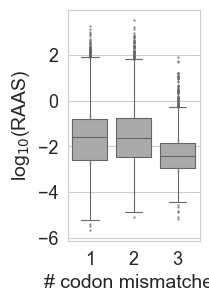

In [20]:
# plot for all dataset together (figure 3a)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(1.7,3))
sns.boxplot(data=plot_df, x='Minimum base error', y='Log substitution ratio', fliersize=0.5, linewidth=0.8, color='#AAAAAA')
plt.ylabel(r'log$_{10}$(RAAS)', fontsize=14);
plt.xlabel('# codon mismatches', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(outdir+'allDS_RAAS_vs_nCodonMismatches.pdf', bbox_inches='tight')

### Extended data figure 3j. T and V tRNA ligase abundances 

In [22]:
aa_name_letter_dict = {'cysteine': 'C', 'aspartate': 'D', 'serine': 'S', 'glutamine': 'Q', 'lysine': 'K',
     'isoleucine': 'I', 'proline': 'P', 'threonine': 'T', 'phenylalanine': 'F', 'asparagine': 'N', 
     'glycine': 'G', 'histidine': 'H', 'leucine': 'L', 'arginine': 'R', 'tryptophan': 'W', 
     'alanine': 'A', 'valine':'V', 'glutamate': 'E', 'tyrosine': 'Y', 'methionine': 'M'}

aa_letter_name_dict = {v:k for k,v in aa_name_letter_dict.items()}

# this dictionary was generated in a separate script using the MaxQuant protein output data
aars_abund_dict = pickle.load(open(dependencies_dir+'refnorm_AARS_abund_dict.p', 'rb'))

In [23]:
def get_boxplot_data(aas):
    """ function to get data for plotting tRNA ligase abundances of 2 amino acids, given a subsitution type"""
    aa1 = aa_letter_name_dict[aas[0]]
    aa2 = aa_letter_name_dict[aas[-1]]
    
    boxplot_rows = []
    cols=['Reporter-distributed\nprecursor intensity', 'tRNA ligase', 'Dataset']
    
    for ds in datasets[:-1]:
        aars_df = aars_abund_dict[ds]
        #aa1_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa1 in row['Unnamed: 0']) and ('mitochondria' not in row['Unnamed: 0'])],:].values[0][1:-1] if ~np.isnan(x)]
        #aa2_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa2 in row['Unnamed: 0']) and ('mitochondria' not in row['Unnamed: 0'])],:].values[0][1:-1] if ~np.isnan(x)]
        aa1_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa1 in i) and ('mitochondria' not in i)],:].values.flatten() if ~np.isnan(x)]
        aa2_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa2 in i) and ('mitochondria' not in i)],:].values.flatten() if ~np.isnan(x)]

        [boxplot_rows.append([val, aa1+'-tRNA ligase', ds]) for val in aa1_aars_vals]
        [boxplot_rows.append([val, aa2+'-tRNA ligase', ds]) for val in aa2_aars_vals]
    boxplot_df = pd.DataFrame(boxplot_rows, columns=cols)
    
    return(boxplot_df)

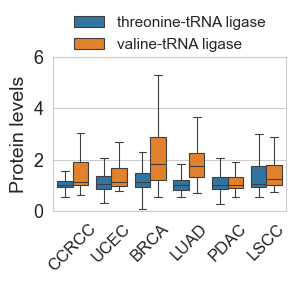

In [24]:
# generate boxplot for substitution type

aas = 'T to V'
boxplot_df = get_boxplot_data(aas)

fig,ax = plt.subplots(figsize=(3,2))
sns.boxplot(data=boxplot_df, y='Reporter-distributed\nprecursor intensity', x='Dataset', hue='tRNA ligase', linewidth=0.8, fliersize=0)
#plt.ylim([0,0.8])
ax.tick_params('y', labelsize=13)
plt.xlabel('')
plt.ylim([0,6])
ax.legend(bbox_to_anchor=(0.5,1.15), fontsize=11, title='', frameon=False, loc='center')
ax.tick_params('x', rotation=45, labelsize=12)
plt.ylabel('Protein levels', fontsize=14)
plt.savefig(outdir+'T2V_AAligase_abund.pdf', bbox_inches='tight')

### Figures 3c,d and Extended Data Figure 3l,m,n and Supplemental Figure 8: Protein turnover analysis with metabolic pulse SILAC data



In [29]:
savitski_dir = proj_dir+'pipeline_output/analysis_dependencies/Savitski/'
aa_subs_dir = savitski_dir+'AA_subs_pipeline/'
val_dir = savitski_dir+'MSFragger_validation/'

cell_types = ['Hepatocytes','Bcells','Monocytes','NKcells']

# read in dataset metadata and create dictionary with values 
metadata = pd.read_csv(val_dir+'Meta.csv')
meta_dict = {}
for i,row in metadata.iterrows():
    meta_dict[row['raw file']] = {'celltype':row['cell type'], 'timepoint':row['time point'], 
                                      'replicate':row['replicate #'], 'time':row['time']}

In [30]:
# read in supplemental data file generated from output of running decode pipeline on the savitski data
# here there is one line per SAAP-BP per sample (replicates on separate lines)

quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_5.SAAP_SILAC_quant.xlsx', index_col=0) 

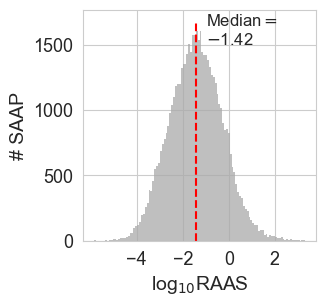

In [31]:
# plot of Hepatocyte RAAS, extended data figure 3l

fig,ax = plt.subplots(figsize=(3,3))
sns.histplot(data=quant_df, x='Light+Heavy RAAS', color='#AAAAAA', linewidth=0)
plt.xlabel('log$_{10}$RAAS', fontsize=14)
plt.ylabel('# SAAP', fontsize=14)
median = np.nanmedian(quant_df['Light+Heavy RAAS'])
plt.plot((median,median), ax.get_ylim(), '--r')
plt.annotate('Median$=$\n'+'$-$'+str(np.round(np.abs(median),2)), xy=(-1,1500), fontsize=12)
plt.xticks([-4,-2,0,2])
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'Savistki_allhepatocyte_RAAS_distribution.pdf', bbox_inches='tight')

""" prepare dataframe for degradataion analysis """
### this file is also provided in the google drive folder pipeline_output/dependencies_dir/Savitski/AA_subs_pipeline/ 
The code reformats the data in quant_df so that there is one line per SAAP-BP pair per cell type.
(more convenient for computing degradation rates)

In [ ]:
""" prepare dataframe for degradataion analysis """
### this file is also provided in the google drive folder pipeline_output/dependencies_dir/Savitski/AA_subs_pipeline/ 

# reformat the data in quant_df so that there is one line per SAAP-BP pair per cell type
# this is more convenient for computing degradation rates 


import warnings
warnings.filterwarnings("ignore")

rep_data_df_list = []
quant_data = quant_df

celltype = 'Hepatocytes'
for celltype in cell_types:
    print(celltype)
    cell_data = quant_data.loc[quant_data['Cell type']==celltype]
    saap_bp = list(set([row['SAAP']+';'+row['BP']+';'+row['AAS'] for i,row in cell_data.iterrows()]))
    print(len(saap_bp))
    timepoints = sorted(list(set(cell_data['Time'].to_list())))
    reps = list(set(cell_data['Replicate'].to_list()))

    cols = ['Cell type', 'SAAP', 'BP', 'AAS', 'CPTAC SAAP', 
            'BP_H_time1_rep1', 'BP_H_time1_rep2', 'BP_H_time2_rep1', 'BP_H_time2_rep2', 'BP_H_time3_rep1', 'BP_H_time3_rep2', 'BP_H_time4_rep1', 'BP_H_time4_rep2',
            'BP_L_time1_rep1', 'BP_L_time1_rep2', 'BP_L_time2_rep1', 'BP_L_time2_rep2', 'BP_L_time3_rep1', 'BP_L_time3_rep2', 'BP_L_time4_rep1', 'BP_L_time4_rep2',
            'BP_time1_rep1', 'BP_time1_rep2', 'BP_time2_rep1', 'BP_time2_rep2', 'BP_time3_rep1', 'BP_time3_rep2', 'BP_time4_rep1', 'BP_time4_rep2',
            'SAAP_H_time1_rep1', 'SAAP_H_time1_rep2', 'SAAP_H_time2_rep1', 'SAAP_H_time2_rep2', 'SAAP_H_time3_rep1', 'SAAP_H_time3_rep2', 'SAAP_H_time4_rep1', 'SAAP_H_time4_rep2',
            'SAAP_L_time1_rep1', 'SAAP_L_time1_rep2', 'SAAP_L_time2_rep1', 'SAAP_L_time2_rep2', 'SAAP_L_time3_rep1', 'SAAP_L_time3_rep2', 'SAAP_L_time4_rep1', 'SAAP_L_time4_rep2',
            'SAAP_time1_rep1', 'SAAP_time1_rep2', 'SAAP_time2_rep1', 'SAAP_time2_rep2', 'SAAP_time3_rep1', 'SAAP_time3_rep2', 'SAAP_time4_rep1', 'SAAP_time4_rep2', 
            'BP_HL_time1_rep1', 'BP_HL_time1_rep2', 'BP_HL_time2_rep1', 'BP_HL_time2_rep2', 'BP_HL_time3_rep1', 'BP_HL_time3_rep2', 'BP_HL_time4_rep1', 'BP_HL_time4_rep2',
            'SAAP_HL_time1_rep1', 'SAAP_HL_time1_rep2', 'SAAP_HL_time2_rep1', 'SAAP_HL_time2_rep2', 'SAAP_HL_time3_rep1', 'SAAP_HL_time3_rep2', 'SAAP_HL_time4_rep1', 'SAAP_HL_time4_rep2', 
            'RAAS_time1_rep1', 'RAAS_time1_rep2', 'RAAS_time2_rep1', 'RAAS_time2_rep2', 'RAAS_time3_rep1', 'RAAS_time3_rep2', 'RAAS_time4_rep1', 'RAAS_time4_rep2',
            'BP_H_mean_time1', 'BP_H_mean_time2', 'BP_H_mean_time3', 'BP_H_mean_time4',
            'BP_L_mean_time1', 'BP_L_mean_time2', 'BP_L_mean_time3', 'BP_L_mean_time4',
            'BP_mean_time1', 'BP_mean_time2', 'BP_mean_time3', 'BP_mean_time4', 
            'SAAP_H_mean_time1', 'SAAP_H_mean_time2', 'SAAP_H_mean_time3', 'SAAP_H_mean_time4',
            'SAAP_L_mean_time1', 'SAAP_L_mean_time2', 'SAAP_L_mean_time3', 'SAAP_L_mean_time4',
            'SAAP_mean_time1', 'SAAP_mean_time2', 'SAAP_mean_time3','SAAP_mean_time4', 
            'BP_HL_mean_time1', 'BP_HL_mean_time2', 'BP_HL_mean_time3', 'BP_HL_mean_time4', 
            'SAAP_HL_mean_time1', 'SAAP_HL_mean_time2', 'SAAP_HL_mean_time3', 'SAAP_HL_mean_time4',
            'RAAS_mean_time1', 'RAAS_mean_time2', 'RAAS_mean_time3', 'RAAS_mean_time4', 'N_timepoints',
            'BP_H_mean', 'BP_H_std','BP_H_CV', 'BP_L_mean', 'BP_L_std','BP_L_CV', 'BP_mean', 'BP_std','BP_CV',
            'SAAP_H_mean', 'SAAP_H_std','SAAP_H_CV', 'SAAP_L_mean', 'SAAP_L_std','SAAP_L_CV','SAAP_mean','SAAP_std','SAAP_CV',
            'BP_HL_mean','BP_HL_std','BP_HL_CV','SAAP_HL_mean','SAAP_HL_std','SAAP_HL_CV','RAAS_mean','RAAS_std','RAAS_CV']
    rep_data_df = pd.DataFrame(index=list(range(len(saap_bp))), columns=cols)

    for i, sba in enumerate(saap_bp):
        if i%1000==0:
            print(i)
        sba_split = sba.split(';')
        saap = sba_split[0]
        bp = sba_split[1]
        aas = sba_split[2]

        rep_data_df.loc[i, 'Cell type'] = celltype
        rep_data_df.loc[i, 'SAAP'] = saap
        rep_data_df.loc[i, 'BP'] = bp
        rep_data_df.loc[i, 'AAS'] = aas

        sba_df = cell_data.loc[(cell_data['SAAP']==saap) & (cell_data['BP']==bp)]
        cptac = sba_df['CPTAC SAAP'].values[0]
        rep_data_df.loc[i,'CPTAC SAAP'] = cptac
        #sba_df

        for j,tp in enumerate(timepoints):
            rep1_df = sba_df.loc[(sba_df['Time']==tp) & (sba_df['Replicate']==1)]
            rep2_df = sba_df.loc[(sba_df['Time']==tp) & (sba_df['Replicate']==2)]

            bp_h_1 = rep1_df['Heavy BP intensity'].values[0]
            bp_h_2 = rep2_df['Heavy BP intensity'].values[0]
            bp_l_1 = rep1_df['Light BP intensity'].values[0]
            bp_l_2 = rep2_df['Light BP intensity'].values[0]
            bp_1 = rep1_df['Light+Heavy BP intensity'].values[0]
            bp_2 = rep2_df['Light+Heavy BP intensity'].values[0]
            bp_hl_1 = rep1_df['H/L BP intensity'].values[0]
            bp_hl_2 = rep2_df['H/L BP intensity'].values[0]
            saap_h_1 = rep1_df['Heavy SAAP intensity'].values[0]
            saap_h_2 = rep2_df['Heavy SAAP intensity'].values[0]
            saap_l_1 = rep1_df['Light SAAP intensity'].values[0]
            saap_l_2 = rep2_df['Light SAAP intensity'].values[0]
            saap_1 = rep1_df['Light+Heavy SAAP intensity'].values[0]
            saap_2 = rep2_df['Light+Heavy SAAP intensity'].values[0]
            saap_hl_1 = rep1_df['H/L SAAP intensity'].values[0]
            saap_hl_2 = rep2_df['H/L SAAP intensity'].values[0]
            raas_1 = rep1_df['Light+Heavy RAAS'].values[0]
            raas_2 = rep2_df['Light+Heavy RAAS'].values[0]

            rep_data_df.loc[i, 'BP_H_time'+str(j+1)+'_rep1'] = bp_h_1
            rep_data_df.loc[i, 'BP_H_time'+str(j+1)+'_rep2'] = bp_h_2
            rep_data_df.loc[i, 'BP_L_time'+str(j+1)+'_rep1'] = bp_l_1
            rep_data_df.loc[i, 'BP_L_time'+str(j+1)+'_rep2'] = bp_l_2
            rep_data_df.loc[i, 'BP_time'+str(j+1)+'_rep1'] = bp_1
            rep_data_df.loc[i, 'BP_time'+str(j+1)+'_rep2'] = bp_2
            rep_data_df.loc[i, 'SAAP_H_time'+str(j+1)+'_rep1'] = saap_h_1
            rep_data_df.loc[i, 'SAAP_H_time'+str(j+1)+'_rep2'] = saap_h_2
            rep_data_df.loc[i, 'SAAP_L_time'+str(j+1)+'_rep1'] = saap_l_1
            rep_data_df.loc[i, 'SAAP_L_time'+str(j+1)+'_rep2'] = saap_l_2
            rep_data_df.loc[i, 'SAAP_time'+str(j+1)+'_rep1'] = saap_1
            rep_data_df.loc[i, 'SAAP_time'+str(j+1)+'_rep2'] = saap_2
            rep_data_df.loc[i, 'BP_HL_time'+str(j+1)+'_rep1'] = bp_hl_1
            rep_data_df.loc[i, 'BP_HL_time'+str(j+1)+'_rep2'] = bp_hl_2
            rep_data_df.loc[i, 'SAAP_HL_time'+str(j+1)+'_rep1'] = saap_hl_1
            rep_data_df.loc[i, 'SAAP_HL_time'+str(j+1)+'_rep2'] = saap_hl_2
            rep_data_df.loc[i, 'RAAS_time'+str(j+1)+'_rep1'] = raas_1
            rep_data_df.loc[i, 'RAAS_time'+str(j+1)+'_rep2'] = raas_2

            rep_data_df.loc[i, 'BP_H_mean_time'+str(j+1)] = np.nanmean([bp_h_1,bp_h_2])
            rep_data_df.loc[i, 'BP_L_mean_time'+str(j+1)] = np.nanmean([bp_l_1,bp_l_2])
            rep_data_df.loc[i, 'BP_mean_time'+str(j+1)] = np.nanmean([bp_1,bp_2])
            rep_data_df.loc[i, 'SAAP_H_mean_time'+str(j+1)] = np.nanmean([saap_h_1,saap_h_2])
            rep_data_df.loc[i, 'SAAP_L_mean_time'+str(j+1)] = np.nanmean([saap_l_1,saap_l_2])
            rep_data_df.loc[i, 'SAAP_mean_time'+str(j+1)] = np.nanmean([saap_1,saap_2])
            rep_data_df.loc[i, 'BP_HL_mean_time'+str(j+1)] = np.nanmean([bp_hl_1,bp_hl_2])
            rep_data_df.loc[i, 'SAAP_HL_mean_time'+str(j+1)] = np.nanmean([saap_hl_1,saap_hl_2])
            rep_data_df.loc[i, 'RAAS_mean_time'+str(j+1)] = np.nanmean([raas_1,raas_2])

        rep_data_df.loc[i, 'N_timepoints'] = len([x for x in rep_data_df.loc[i,[c for c in rep_data_df.columns if 'RAAS_mean_time' in c]] if ~np.isnan(x)])

        bp_h_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_H_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_H_mean'] = np.nanmean(bp_h_vals)
        rep_data_df.loc[i, 'BP_H_std'] = np.nanstd(bp_h_vals)
        rep_data_df.loc[i, 'BP_H_CV'] = np.nanstd(bp_h_vals)/np.nanmean(bp_h_vals)
        bp_l_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_L_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_L_mean'] = np.nanmean(bp_l_vals)
        rep_data_df.loc[i, 'BP_L_std'] = np.nanstd(bp_l_vals)
        rep_data_df.loc[i, 'BP_L_CV'] = np.nanstd(bp_l_vals)/np.nanmean(bp_l_vals)
        bp_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_mean'] = np.nanmean(bp_vals)
        rep_data_df.loc[i, 'BP_std'] = np.nanstd(bp_vals)
        rep_data_df.loc[i, 'BP_CV'] = np.nanstd(bp_vals)/np.nanmean(bp_vals)
        saap_h_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_H_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_H_mean'] = np.nanmean(saap_h_vals)
        rep_data_df.loc[i, 'SAAP_H_std'] = np.nanstd(saap_h_vals)
        rep_data_df.loc[i, 'SAAP_H_CV'] = np.nanstd(saap_h_vals)/np.nanmean(saap_h_vals)
        saap_l_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_L_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_L_mean'] = np.nanmean(saap_l_vals)
        rep_data_df.loc[i, 'SAAP_L_std'] = np.nanstd(saap_l_vals)
        rep_data_df.loc[i, 'SAAP_L_CV'] = np.nanstd(saap_l_vals)/np.nanmean(saap_l_vals)
        saap_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_mean'] = np.nanmean(saap_vals)
        rep_data_df.loc[i, 'SAAP_std'] = np.nanstd(saap_vals)
        rep_data_df.loc[i, 'SAAP_CV'] = np.nanstd(saap_vals)/np.nanmean(saap_vals)
        bp_hl_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_HL_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_HL_mean'] = np.nanmean(bp_hl_vals)
        rep_data_df.loc[i, 'BP_HL_std'] = np.nanstd(bp_hl_vals)
        rep_data_df.loc[i, 'BP_HL_CV'] = np.nanstd(bp_hl_vals)/np.nanmean(bp_hl_vals)
        saap_hl_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_HL_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_HL_mean'] = np.nanmean(saap_hl_vals)
        rep_data_df.loc[i, 'SAAP_HL_std'] = np.nanstd(saap_hl_vals)
        rep_data_df.loc[i, 'SAAP_HL_CV'] = np.nanstd(saap_hl_vals)/np.nanmean(saap_hl_vals)
        raas_vals = [10**x for x in rep_data_df.loc[i,[x for x in rep_data_df.columns if 'RAAS_mean_time' in x]].to_list()]
        rep_data_df.loc[i, 'RAAS_mean'] = np.log10(np.nanmean(raas_vals))
        rep_data_df.loc[i, 'RAAS_std'] = np.nanstd(raas_vals)
        rep_data_df.loc[i, 'RAAS_CV'] = np.nanstd(raas_vals)/np.nanmean(raas_vals)

    rep_data_df_list.append(rep_data_df)

In [ ]:
# add columns with log of the abundance values for all heavy and light peptides and save file

new_rep_data_df_list = []
for i,rep_data_df in enumerate(rep_data_df_list):
    celltype = rep_data_df['Cell type'].values[0]
    print(celltype)
    cell_meta = metadata.loc[metadata['cell type']==celltype]
    timepoints = list(set(cell_meta['time point'].to_list()))
    timepoints = [str(y)+'h' for y in sorted([int(x.split('h')[0]) for x in timepoints])]
    for j,tp in enumerate(timepoints): 
        print(tp)
        rep_data_df['BP_H_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_H_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_H_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_H_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_L_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_L_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_L_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_L_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_H_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_H_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_H_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_H_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_L_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_L_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_L_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_L_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_H_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_H_time'+str(j+1)+'_rep1'], row['BP_H_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['BP_L_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_L_time'+str(j+1)+'_rep1'], row['BP_L_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['BP_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_time'+str(j+1)+'_rep1'], row['BP_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_H_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_H_time'+str(j+1)+'_rep1'], row['SAAP_H_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_L_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_L_time'+str(j+1)+'_rep1'], row['SAAP_L_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_time'+str(j+1)+'_rep1'], row['SAAP_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]

        rep_data_df['BP_HL_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_HL_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_HL_time'+str(j+1)+'_rep1_log+1'] = [np.log10(x+1) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_HL_time'+str(j+1)+'_rep2_log+1'] = [np.log10(x+1) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1_log+1'] = [np.log10(x+1) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2_log+1'] = [np.log10(x+1) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2'].to_list()]

        rep_data_df['BP_HL_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_HL_time'+str(j+1)+'_rep1'], row['BP_HL_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_HL_time'+str(j+1)+'_rep1'], row['SAAP_HL_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['BP_HL_time'+str(j+1)+'_mean_log+1'] = [np.log10(np.nanmean([row['BP_HL_time'+str(j+1)+'_rep1'], row['BP_HL_time'+str(j+1)+'_rep2']])+1) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_mean_log+1'] = [np.log10(np.nanmean([row['SAAP_HL_time'+str(j+1)+'_rep1'], row['SAAP_HL_time'+str(j+1)+'_rep2']])+1) for i,row in rep_data_df.iterrows()]
    new_rep_data_df_list.append(rep_data_df)
    
rep_data_df_all = pd.concat(rep_data_df_list)
rep_data_df.replace(np.inf, np.nan, inplace=True)
rep_data_df.replace(-np.inf, np.nan, inplace=True)
rep_data_df_all.to_csv(aa_subs_dir+'Median_normalized_Replicate_data_all_celltypes.csv')

In [34]:
# function to compute degradation rates 

def get_model_params(x,y):
    """ 
    Generate linear regression model to fit peptide abundance data to time points
    input: x - timepoints; y - abundance data (or H/L to compute degradation rates)
    output: slope of regression (this is the degradation rate when fitting H/L), R^2 of the fit, and predicted y values
    """
    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    model = LinearRegression(fit_intercept=False)
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0]
    score = model.score(x,y)
    return(slope, score, y_pred)

In [ ]:
# compute degradation rates of heavy and light and H/L ratio 

bp_deg_rates = []
saap_deg_rates = []
bp_deg_r2_list = []
saap_deg_r2_list = []
bp_deg_pred_list = []
saap_deg_pred_list = []
n_bp_times_in_deg = []
n_saap_times_in_deg = []

bp_light_slope_list = []
saap_light_slope_list = []
bp_light_r2_list = []
saap_light_r2_list = []
bp_light_pred_list = []
saap_light_pred_list = []

bp_heavy_slope_list = []
saap_heavy_slope_list = []
bp_heavy_r2_list = []
saap_heavy_r2_list = []
bp_heavy_pred_list = []
saap_heavy_pred_list = []

i=0
row = rep_data_df_all.loc[i]

for i,row in rep_data_df_all.iterrows():
    if i%1000==0:
        print(i)
    celltype = row['Cell type']
    x = ordered_times[celltype]

    bp_hl = [row['BP_HL_time'+str(j)+'_mean_log+1'] for j in range(1,5)]
    x_bp_hl = [x[j] for j in range(len(x)) if ~np.isnan(bp_hl[j])]
    bp_hl = [x for x in bp_hl if ~np.isnan(x)]
    n_bp = len(bp_hl)

    saap_hl = [row['SAAP_HL_time'+str(j)+'_mean_log+1'] for j in range(1,5)]
    x_saap_hl = [x[j] for j in range(len(x)) if ~np.isnan(saap_hl[j])]
    saap_hl = [x for x in saap_hl if ~np.isnan(x)]
    n_saap = len(saap_hl)

    bp_deg_slope = saap_deg_slope = np.nan
    bp_deg_r2 = saap_deg_r2 = np.nan
    bp_deg_pred = saap_deg_pred = np.nan
    if len(bp_hl)>0:
        bp_deg_slope, bp_deg_r2, bp_deg_pred = get_model_params(x_bp_hl, bp_hl)
    if len(saap_hl)>0:
        saap_deg_slope, saap_deg_r2, saap_deg_pred = get_model_params(x_saap_hl, saap_hl)

    bp_deg_rates.append(bp_deg_slope)
    saap_deg_rates.append(saap_deg_slope)
    bp_deg_r2_list.append(bp_deg_r2)
    saap_deg_r2_list.append(saap_deg_r2)
    bp_deg_pred_list.append(bp_deg_pred)
    saap_deg_pred_list.append(saap_deg_pred)
    n_bp_times_in_deg.append(n_bp)
    n_saap_times_in_deg.append(n_saap)


    bp_light = [row['BP_L_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_bp_light = [x[j] for j in range(len(x)) if ~np.isnan(bp_light[j])]
    bp_light = [x for x in bp_light if ~np.isnan(x)]

    saap_light = [row['SAAP_L_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_saap_light = [x[j] for j in range(len(x)) if ~np.isnan(saap_light[j])]
    saap_light = [x for x in saap_light if ~np.isnan(x)]

    bp_light_slope = saap_light_slope = np.nan
    bp_light_r2 = saap_light_r2 = np.nan
    bp_light_pred = saap_light_pred = np.nan
    if len(bp_light)>0:
        bp_light_slope, bp_light_r2, bp_light_pred = get_model_params(x_bp_light, bp_light)
    if len(saap_light)>0:
        saap_light_slope, saap_light_r2, saap_light_pred = get_model_params(x_saap_light, saap_light)

    bp_light_slope_list.append(bp_light_slope)
    saap_light_slope_list.append(saap_light_slope)
    bp_light_r2_list.append(bp_light_r2)
    saap_light_r2_list.append(saap_light_r2)
    bp_light_pred_list.append(bp_light_pred)
    saap_light_pred_list.append(saap_light_pred)


    bp_heavy = [row['BP_H_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_bp_heavy = [x[j] for j in range(len(x)) if ~np.isnan(bp_heavy[j])]
    bp_heavy = [x for x in bp_heavy if ~np.isnan(x)]

    saap_heavy = [row['SAAP_H_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_saap_heavy = [x[j] for j in range(len(x)) if ~np.isnan(saap_heavy[j])]
    saap_heavy = [x for x in saap_heavy if ~np.isnan(x)]

    bp_heavy_slope = saap_heavy_slope = np.nan
    bp_heavy_r2 = saap_heavy_r2 = np.nan
    bp_heavy_pred = saap_heavy_pred = np.nan
    if len(bp_heavy)>0:
        bp_heavy_slope, bp_heavy_r2, bp_heavy_pred = get_model_params(x_bp_heavy, bp_heavy)
    if len(saap_heavy)>0:
        saap_heavy_slope, saap_heavy_r2, saap_heavy_pred = get_model_params(x_saap_heavy, saap_heavy)

    bp_heavy_slope_list.append(bp_heavy_slope)
    saap_heavy_slope_list.append(saap_heavy_slope)    
    bp_heavy_r2_list.append(bp_heavy_r2)
    saap_heavy_r2_list.append(saap_heavy_r2)
    bp_heavy_pred_list.append(bp_heavy_pred)
    saap_heavy_pred_list.append(saap_heavy_pred)
    
rep_data_df_all['BP_deg_rate'] = bp_deg_rates
rep_data_df_all['SAAP_deg_rate'] = saap_deg_rates
rep_data_df_all['BP_deg_rate_log'] = [np.log10(x) for x in rep_data_df_all['BP_deg_rate'].to_list()]
rep_data_df_all['SAAP_deg_rate_log'] = [np.log10(x) for x in rep_data_df_all['SAAP_deg_rate'].to_list()]
rep_data_df_all['BP_N_timepoints_in_deg'] = n_bp_times_in_deg
rep_data_df_all['SAAP_N_timepoints_in_deg'] = n_saap_times_in_deg

rep_data_df_all['BP_deg_r2'] = bp_deg_r2_list
rep_data_df_all['SAAP_deg_r2'] = saap_deg_r2_list
rep_data_df_all['BP_deg_predicted'] = bp_deg_pred_list
rep_data_df_all['SAAP_deg_predicted'] = saap_deg_pred_list

rep_data_df_all['BP_light_slope'] = bp_light_slope_list
rep_data_df_all['SAAP_light_slope'] = saap_light_slope_list
rep_data_df_all['BP_light_r2'] = bp_light_r2_list
rep_data_df_all['SAAP_light_r2'] = saap_light_r2_list
rep_data_df_all['BP_light_predicted'] = bp_light_pred_list
rep_data_df_all['SAAP_light_predicted'] = saap_light_pred_list

rep_data_df_all['BP_heavy_slope'] = bp_heavy_slope_list
rep_data_df_all['SAAP_heavy_slope'] = saap_heavy_slope_list
rep_data_df_all['BP_heavy_r2'] = bp_heavy_r2_list
rep_data_df_all['SAAP_heavy_r2'] = saap_heavy_r2_list
rep_data_df_all['BP_heavy_predicted'] = bp_heavy_pred_list
rep_data_df_all['SAAP_heavy_predicted'] = saap_heavy_pred_list

# compute ratio of SAAP degradation rate to BP degradation rate 
rep_data_df_all['SAAP_BP_deg_rate'] = [row['SAAP_deg_rate']/row['BP_deg_rate'] for i,row in rep_data_df_all.iterrows()]
rep_data_df_all['SAAP_BP_deg_rate_log'] = [np.log2(x) for x in rep_data_df_all['SAAP_BP_deg_rate'].to_list()]

rep_data_df_all.to_csv(outdir+'Median_normalized_Replicate_data_all_celltypes.csv')

# Read in data file here if did not reproduce analysis from scratch

In [32]:
rep_data_df_all = pd.read_csv(savitski_dir+'AA_subs_pipeline/Median_normalized_Replicate_data_all_celltypes.csv', index_col=0)

<>:56: SyntaxWarning: invalid escape sequence '\i'
<>:56: SyntaxWarning: invalid escape sequence '\i'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/3051006187.py:56: SyntaxWarning: invalid escape sequence '\i'
  plt.legend(fontsize=12,handles=handles, labels=['CPTAC+Healthy', 'Savitski, $\it{et\ al.}$'], handletextpad=0.1,
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/3051006187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_data_df.dropna(inplace=True, subset=['SAAP_BP_deg_rate_log', 'RAAS_mean'])


-0.15669453200900899 3.589205839864135e-20
-0.1542019942060785 1.6661524248316394e-15
-0.16804777928146483 2.787462600778197e-06


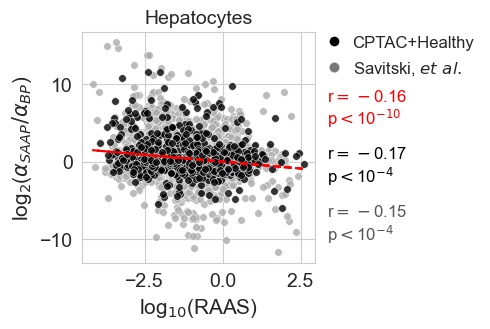

In [37]:
# plot ratio of SAAP degradation to BP degradation vs RAAS for given cell type. Figure 2l, extended data figure 3 m,n.

celltype = 'Hepatocytes' # change for other cell types 

rep_data_df = rep_data_df_all.loc[rep_data_df_all['Cell type']==celltype]
#rep_data_df = rep_data_df.loc[(rep_data_df['BP_N_timepoints_in_deg']>2) & (rep_data_df['SAAP_N_timepoints_in_deg']>2)]
rep_data_df.dropna(inplace=True, subset=['SAAP_BP_deg_rate_log', 'RAAS_mean'])


sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))

subset1_df = rep_data_df.loc[rep_data_df['CPTAC SAAP']==False]
subset2_df = rep_data_df.loc[rep_data_df['CPTAC SAAP']==True]

sns.scatterplot(data=rep_data_df, x='RAAS_mean', y='SAAP_BP_deg_rate_log', s=30, alpha=0, hue='CPTAC SAAP', palette=['#AAAAAA', 'k'])#, palette='RdBu_r')
sns.scatterplot(data=subset1_df, x='RAAS_mean', y='SAAP_BP_deg_rate_log', s=30, alpha=0.8, color='#AAAAAA')#, palette='RdBu_r')
sns.scatterplot(data=subset2_df, x='RAAS_mean', y='SAAP_BP_deg_rate_log', s=30, alpha=0.8, color='k')#, palette='RdBu_r')

#scatter = plt.scatter(data=hep_data, x='Light+Heavy RAAS', y='RTO', s=30, alpha=0.5, edgecolor='w', linewidth=0.7)
vect2 = [float(x) for x in rep_data_df['SAAP_BP_deg_rate_log'].values]
vect1 = [float(x) for x in rep_data_df['RAAS_mean'].values]
y_vals = get_model_params(vect1,vect2)[2]
plt.plot(vect1, y_vals, '--r')

vect1_2 = subset1_df['SAAP_BP_deg_rate_log'].values
vect1_1 = subset1_df['RAAS_mean'].values
y1_vals = get_model_params(vect1_1, vect1_2)[2]
#plt.plot(vect1_1, y1_vals, '--', color='#555555')

vect2_2 = subset2_df['SAAP_BP_deg_rate_log'].values
vect2_1 = subset2_df['RAAS_mean'].values
y2_vals = get_model_params(vect2_1,vect2_2)[2]
#plt.plot(vect2_1, y2_vals, '--', color='k')

r,p = sp.stats.pearsonr(vect1, vect2)
r1,p1 = sp.stats.pearsonr(vect1_1, vect1_2)
r2,p2 = sp.stats.pearsonr(vect2_1, vect2_2)
print(r,p)
print(r1,p1)
print(r2,p2)

ax.annotate('r$=-$'+str(np.round(np.abs(r),2)), xy=(1.05,0.7), xycoords='axes fraction', fontsize=12, color='r')
ax.annotate('p$<$10$^{-10}$', xy=(1.05,0.6), xycoords='axes fraction', fontsize=12,color='r')
#ax.annotate('p$=$0.95', xy=(1.05,0.6), xycoords='axes fraction', fontsize=12, color='r')

ax.annotate('r$=-$'+str(np.round(np.abs(r2),2)), xy=(1.05,0.45), xycoords='axes fraction', fontsize=12, color='k')
ax.annotate('p$<$10$^{-4}$', xy=(1.05,0.35), xycoords='axes fraction', fontsize=12, color='k')
#ax.annotate('p$=$0.06', xy=(1.05,0.35), xycoords='axes fraction', fontsize=12, color='k')

ax.annotate('r$=-$'+str(np.round(np.abs(r1),2)), xy=(1.05,0.2), xycoords='axes fraction', fontsize=12, color='#555555')
ax.annotate('p$<$10$^{-4}$', xy=(1.05,0.1), xycoords='axes fraction', fontsize=12, color='#555555')
#ax.annotate('p$=$0.73', xy=(1.05,0.1), xycoords='axes fraction', fontsize=12, color='#555555')

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8), Line2D([0], [0], marker='o', color='w', markerfacecolor='#555555', markersize=8, alpha=0.8)]
plt.legend(fontsize=12,handles=handles, labels=['CPTAC+Healthy', 'Savitski, $\it{et\ al.}$'], handletextpad=0.1,
          bbox_to_anchor=(1.75,1.05), frameon=False, loc='upper right')

ax.tick_params('both', labelsize=14)
plt.ylabel('log$_{2}$('+r'$\alpha_{SAAP}$'+'$/$'+r'$\alpha_{BP}$'+')', fontsize=15)
plt.xlabel('log$_{10}$(RAAS)', fontsize=15)

plt.title(celltype, fontsize=14)
#plt.title('B Cells', fontsize=14)

plt.savefig(outdir+celltype+'_log2_SAAP_BP_deg_vs_RAAS.png', dpi=300, bbox_inches='tight')

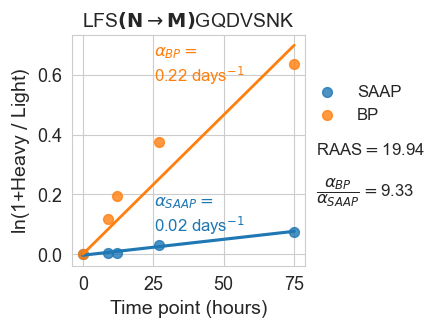

In [38]:
# plot example of H/L ratios relative to time point to illustrate computation. Figure 2k


# filter rep_data_df_all for peptides with no missing data, high R2, high RAAS and low SAAP degradation to find example
rep_data_df = rep_data_df_all.loc[rep_data_df_all['Cell type']=='Hepatocytes']
rep_data_df = rep_data_df.loc[(rep_data_df['SAAP_N_timepoints_in_deg']==4) & (rep_data_df['BP_N_timepoints_in_deg']==4)]
rep_data_df = rep_data_df.loc[(rep_data_df['SAAP_deg_r2']>=0.5) & (rep_data_df['BP_deg_r2']>=0.5)]
example_df = rep_data_df.loc[(rep_data_df['SAAP_BP_deg_rate_log']<0) & (rep_data_df['RAAS_mean']>1)]
cell_quant_data = quant_df.loc[quant_df['Cell type']=='Hepatocytes']

example_row = example_df.loc[[i for i,row in example_df.iterrows() if row['SAAP']=='LFSNGQDVSNK']]

# extract data for plot. convert log10 to ln. 
saap = example_row['SAAP'].values[0]
bp = example_row['BP'].values[0]
aas = example_row['AAS'].values[0]
raas = example_row['RAAS_mean'].values[0]
saap_deg = np.log(10**(example_row['SAAP_deg_rate'].values[0]))
bp_deg = np.log(10**(example_row['BP_deg_rate'].values[0]))
saap_bp_deg = saap_deg/bp_deg

saap_deg_day = 24*saap_deg
bp_deg_day = 24*bp_deg

#if read in rep_data_df
saap_hl_pred = [np.log(10**float(x)) for x in example_row['SAAP_deg_predicted'].values[0][1:-1].split(' ') if len(x)>0]
bp_hl_pred = [np.log(10**float(x)) for x in example_row['BP_deg_predicted'].values[0][1:-1].split(' ') if len(x)>0]

# if generated new rep_data_df
#saap_hl_pred = [np.log(10**x) for x in example_row['SAAP_deg_predicted'].values[0]]
#bp_hl_pred = [np.log(10**x) for x in example_row['BP_deg_predicted'].values[0]]

row_quant = cell_quant_data.loc[(cell_quant_data['SAAP']==saap) & (cell_quant_data['BP']==bp)]
tps = sorted(list(set(row_quant['Time'])))
saap_light_tps = []
saap_heavy_tps = []
bp_light_tps = []
bp_heavy_tps = []
saap_hl_tps = []
bp_hl_tps = []

for tp in tps:
    tp_quant = row_quant.loc[row_quant['Time']==tp]
    rep1_row = tp_quant.loc[tp_quant['Replicate']==1]
    rep2_row = tp_quant.loc[tp_quant['Replicate']==2]
    time = rep1_row['Time'].values[0]
    hl_saap = np.nanmean([np.log(rep1_row['H/L SAAP intensity'].values[0]+1), np.log(rep2_row['H/L SAAP intensity'].values[0]+1)])
    hl_bp = np.nanmean([np.log(rep1_row['H/L BP intensity'].values[0]+1), np.log(rep2_row['H/L BP intensity'].values[0]+1)])
    saap_hl_tps.append(hl_saap)
    bp_hl_tps.append(hl_bp)

    
# plot figure 2k
fig,ax = plt.subplots(figsize=(3,3))
tps = [0]+tps
saap_hl_tps = [0] + saap_hl_tps
bp_hl_tps = [0] + bp_hl_tps
bp_hl_pred = [0] + bp_hl_pred

sns.regplot(x=tps, y=saap_hl_tps, label='SAAP_H/L', ci=None, scatter_kws={'s':50})
sns.regplot(x=tps, y=bp_hl_tps, label='BP_H/L', ci=None, scatter_kws={'s':50}, line_kws={'linewidth':0})
sns.lineplot(x=tps, y=bp_hl_pred, color=colors[1], linewidth=2)
aas_idx = [i for i,x in enumerate(saap) if bp[i]!=x][0]
plt.title(saap[:aas_idx]+r'$\bf(N$'+r'$\rightarrow$'+r'$\bf M)$'+saap[aas_idx+1:], fontsize=14)
ax.tick_params('both', labelsize=13)
plt.ylabel('ln(1+Heavy $/$ Light)', fontsize=14)
plt.xlabel('Time point (hours)', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels =['SAAP', 'BP'], bbox_to_anchor=(0.96,0.85), frameon=False, loc='upper left', fontsize=12)
plt.annotate('RAAS$=$'+str(np.round(10**raas,2)), xy=(1.05,0.48), xycoords='axes fraction', fontsize=12)
plt.annotate(r'$\dfrac{\alpha_{BP}}{\alpha_{SAAP}}$'+'$=$'+str(np.round(np.abs(1/saap_bp_deg),2)), xy=(1.05,0.3), xycoords='axes fraction', fontsize=12)
plt.annotate(r'$\alpha_{SAAP}=$'+'\n'+str(np.round(saap_deg_day,2))+' days$^{-1}$',xy=(0.35,0.15), xycoords='axes fraction', color=colors[0], fontsize=12)
plt.annotate(r'$\alpha_{BP}=$'+'\n'+str(np.round(bp_deg_day,2))+' days$^{-1}$',xy=(0.35,0.8), xycoords='axes fraction', color=colors[1], fontsize=12)
plt.savefig(outdir+'saap_bp_hl_example4fig2.pdf', bbox_inches='tight')


<>:10: SyntaxWarning: invalid escape sequence '\|'
<>:10: SyntaxWarning: invalid escape sequence '\|'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/2016565662.py:10: SyntaxWarning: invalid escape sequence '\|'
  all_mtps = [x for x in fasta_entries if re.match('MTP\|', x)] # these come from Savitski DP search


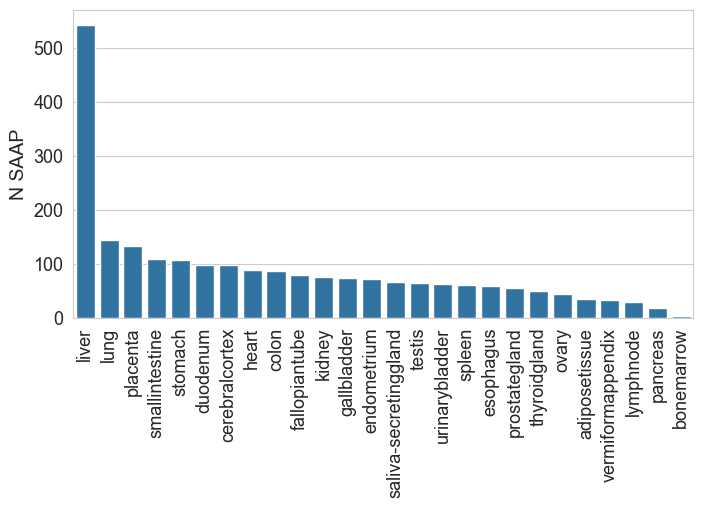

In [44]:
# see which tissues SAAP identified in this dataset were identified in in the healthy human tissue data 
# Supp. Figure 8a

celltype = 'Hepatocytes'
pep_df = pd.read_csv(val_dir+celltype+'/combined_modified_peptide_label_quant.tsv', sep='\t')

fasta = open(savitski_dir+'databases/2024-07-21-decoys-contam-human_MTP_'+celltype+'.fasta.fas', 'r').read()
fasta_entries = [x for x in fasta.split('>')]
allpeps = list(set(pep_df['Peptide Sequence'].to_list()))
all_mtps = [x for x in fasta_entries if re.match('MTP\|', x)] # these come from Savitski DP search 
all_saap = [x for x in fasta_entries if re.match('SAAP_', x)] # these come from CPTAC/label-free DP searches

all_mtp_ids = [x.split('\n')[0] for x in all_mtps]
all_mtp_seqs = [x.split('\n')[1] for x in all_mtps]
all_saap = [x for x in all_saap if len(x.split('\n'))>1]
all_saap_ids = [x.split('\n')[0] for x in all_saap]
all_saap_seqs = [x.split('\n')[1] for x in all_saap]

# get all peptide sequences that were validated by MSFragger search 
mtp_saap_peps = [x for x in allpeps if x in all_mtp_seqs and x in all_saap_seqs]
mtp_peps = [x for x in allpeps if x in all_mtp_seqs and x not in all_saap_seqs]
saap_peps = [x for x in allpeps if x not in all_mtp_seqs and x in all_saap_seqs]
other_peps = [x for x in allpeps if x not in all_mtp_seqs and x not in all_saap_seqs]

val_saap = mtp_saap_peps + saap_peps 
set_tissues = list(set(filt_prec_quant_df['TMT/Tissue'].to_list()))
set_tissues = [x for x in set_tissues if not re.match('S[1-9]', x)]

# generate dataframe with the number of validated SAAP that were found in each type of healthy tissue
plot_rows = []
plot_cols = ['Tissue', 'N SAAP']
for tissue in set_tissues:
    tissue_ct = 0
    for saap in val_saap:
        tissues = filt_prec_quant_df.loc[filt_prec_quant_df['SAAP']==saap, 'TMT/Tissue'].to_list()
        if tissue in tissues:
            tissue_ct+=1
    plot_rows.append([tissue, tissue_ct])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df.sort_values('N SAAP', ascending=False, inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='Tissue', y='N SAAP')
plt.xticks(rotation=90);
ax.tick_params('both', labelsize=13)
plt.ylabel('N SAAP', fontsize=14)
plt.xlabel('')

plt.savefig(outdir+'MSFragger_validation_SAAP_in_healthy_tissues.pdf', bbox_inches='tight')

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/1938079436.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.dropna(inplace=True, subset=['Light+Heavy SAAP intensity'])
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/1938079436.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.dropna(inplace=True, subset=['Light+Heavy SAAP intensity'])
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/1938079436.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

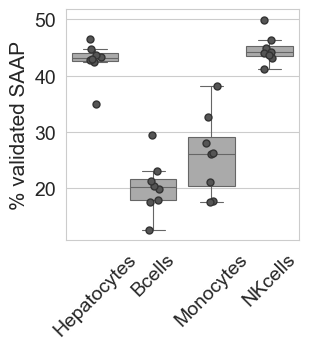

In [45]:
# generate dataframe for plot of how many candidate SAAP from Savitski DP search were validated by MSFragger 
# supp. figure 8b

cptac_saap_list = open(dependencies_dir+'unique_CPTAC_SAAP_BP_list.txt', 'r').readlines()
cptac_saap_list = [x.split('\n')[0] for x in cptac_saap_list]
cptac_saap_list = [x.split('\t') for x in cptac_saap_list]
cptac_saaps = [x[0] for x in cptac_saap_list]

ordered_timepoints = {}
for celltype in cell_types:
    cell_meta = metadata.loc[metadata['cell type']==celltype]
    timepoints = list(set(cell_meta['time point'].to_list()))
    timepoints = [str(y)+'h' for y in sorted([int(x.split('h')[0]) for x in timepoints])]
    ordered_timepoints[celltype] = timepoints
ordered_times = {k:[int(x.split('h')[0]) for x in v] for k,v in ordered_timepoints.items()}    
    

plot_rows = []
plot_cols = ['Cell type', 'Sample', '% peptides', '% type']

for celltype in cell_types:
    qmtp_dict = pickle.load(open(aa_subs_dir+'qMTP_dict_'+celltype+'.p','rb'))
    cand_seqs = list(set([x for y in list(qmtp_dict['mistranslated sequence'].values()) for x in y]))
    all_seqs = cand_seqs + cptac_saaps
    cell_df = quant_df.loc[quant_df['Cell type']==celltype]
    cell_times = ordered_times[celltype]
    reps = [1,2]

    all_val_seqs = list(set(cell_df['SAAP'].to_list()))
    for time in cell_times:
        for rep in reps:
            sample = str(time)+'_'+str(rep)
            sample_df = cell_df.loc[(cell_df['Time']==time) & (cell_df['Replicate']==rep)]
            sample_df.dropna(inplace=True, subset=['Light+Heavy SAAP intensity'])
            val_seqs = list(set(sample_df['SAAP'].to_list()))
            pcnt_sav_saap = 100*len([x for x in cand_seqs if x in val_seqs])/len(cand_seqs)
            pcnt_cptac_saap = 100*len([x for x in cptac_saaps if x in val_seqs])/len(cptac_saaps)
            pcnt_all_saap = 100*len([x for x in all_seqs if x in val_seqs])/len(all_seqs)
            plot_rows.append([celltype, sample, pcnt_sav_saap, 'Savitskit SAAP'])
            plot_rows.append([celltype, sample, pcnt_cptac_saap, 'CPTAC SAAP'])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(3,3))

plot_df = plot_df.loc[plot_df['% type']=='Savitskit SAAP']
sns.boxplot(data=plot_df, x='Cell type', y='% peptides', linewidth=0.8, fliersize=0, dodge=True, saturation=0.8, color='#AAAAAA')
sns.stripplot(data=plot_df, x='Cell type', y='% peptides', linewidth=1, dodge=True, color='#555555')
plt.yticks(fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.ylabel('% validated SAAP', fontsize=15)
plt.savefig(outdir+'percent_validated_boxplot.pdf', bbox_inches='tight')

### Figures 3e,f: Protein turnover of shared peptides compared to SAAP and BP


In [47]:
set_saap_dict = pickle.load(open(dependencies_dir+'Turnover_SAAP_metadata.p', 'rb'))
uniprot_fasta = open(dependencies_dir+'uniprotkb_reviewed_9606_2023_11_30.fasta', 'r').read()
uniprot_fasta = ''.join(uniprot_fasta.splitlines())

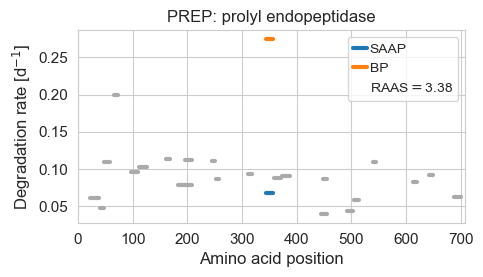

In [49]:
# create plot with peptide intensity on the y axis, protein position on the x axis and plot a data point for each peptide
def get_pep_idx_range(pep, protseq):
    pattern = re.compile(re.escape(pep))  # Escape the substring for literal matching
    for match in pattern.finditer(protseq):
        start, end = match.start(), match.end()-1
    return(start, end)


k = 23
v = set_saap_dict[k]
saap = v['SAAP']
bp = v['BP']
prot_list = v['Protein']
gene_list = v['Genes']
uniprot_list = v['Uniprot']
refprot_list = v['Refprot']
protseq = v['Protein_sequence']
x_vals = [i for i in range(len(protseq))]
saap_cells = v['Cell_types']

for cell in saap_cells:
    saap_rate = v['SAAP_turnover'][cell]
    saap_rate_day = saap_rate*24
    bp_rate = v['BP_turnover'][cell]
    bp_rate_day = bp_rate*24
    peps = list(v['Turnover_rates'][cell].keys())
    rates = list(v['Turnover_rates'][cell].values())
    raas = v['RAAS'][cell]

    fig,ax = plt.subplots(figsize=(5,2.5))
    plt.xlim([x_vals[0], x_vals[-1]])
    plt.xticks()
    #plt.yscale('log')

    bp_range = saap_range = get_pep_idx_range(bp, protseq)
    plt.plot([saap_range[0], saap_range[1]], (saap_rate_day, saap_rate_day), color=colors[0], label='SAAP', linewidth=3)
    plt.plot([bp_range[0], bp_range[1]], (bp_rate_day, bp_rate_day), color=colors[1], label='BP', linewidth=3)

    ranges = []
    for pep in peps:
        if pep in protseq:
            start, end = get_pep_idx_range(pep, protseq)
            ranges.append([start, end])
        else: ranges.append([0,0])

    for i,pep in enumerate(peps):
        if len(re.findall(pep.upper(), uniprot_fasta))==1:
            pep_rate = rates[i]
            if pep!=bp and ~np.isnan(pep_rate):
                pep_rate_day = pep_rate*24
                pep_range = ranges[i]
                pep_start = pep_range[0]
                pep_end = pep_range[1]
                #print(pep)
                #print(pep_range)
                
                if i==0:
                    plt.plot((pep_start, pep_end), (pep_rate_day, pep_rate_day), color='#AAAAAA', label='Shared peptide', linewidth=3) # only have once in legend
                else:
                    plt.plot((pep_start, pep_end), (pep_rate_day, pep_rate_day), color='#AAAAAA', linewidth=3)


    plt.ylabel(r'Degradation rate [d$^{-1}$]', fontsize=12)
    plt.xlabel('Amino acid position', fontsize=12)
    ax.tick_params('both', labelsize=11)

    #plt.ylim([0,1])
    
    handles, labels = ax.get_legend_handles_labels()
    handles = handles + [Line2D([],[], c='w',marker=None)]
    labels = labels + ['RAAS$=$'+'{:.2f}'.format(10**raas)]
    plt.legend(handles=handles, labels=labels, fontsize=10, handletextpad=0.2, handlelength=1, bbox_to_anchor=(1,1))#, ncol=2)#, loc='lower left', )
    
    if len(gene_list)>0:
        plot_str = gene_list[0]
    else:
        plot_str = prot_list[0]

    
    plot_str = 'PREP: prolyl endopeptidase'
    plt.title(plot_str)# + ': '+prot)
    #plt.yscale('log')
    plt.savefig(outdir+plot_str+'_'+cell+'.pdf', bbox_inches='tight')
    plt.savefig(outdir+plot_str+'_'+cell+'.png',dpi=300, bbox_inches='tight')
    #plt.close()


In [52]:
shared_pep_turnover_dict = pickle.load(open(dependencies_dir+'Savitski/AA_subs_pipeline/Shared_peptide_turnover_dict.p','rb'))


for k,v in shared_pep_turnover_dict.items():
    saap_cells = v['Cell_types']
    shared_pep_turnover_dict[k]['SAAP_shared_turnover_ratio'] = {}
    shared_pep_turnover_dict[k]['BP_shared_turnover_ratio'] = {}
    shared_pep_turnover_dict[k]['SAAP_BP_turnover_ratio'] = {}
    for cell in saap_cells:
        saap_to = v['SAAP_turnover'][cell]
        bp_to = v['BP_turnover'][cell]
        shared_to = np.nanmedian(list(v['Turnover_rates'][cell].values()))
        saap_shared_ratio = saap_to/shared_to
        bp_shared_ratio = bp_to/shared_to
        shared_pep_turnover_dict[k]['SAAP_shared_turnover_ratio'][cell] = saap_shared_ratio
        shared_pep_turnover_dict[k]['BP_shared_turnover_ratio'][cell] = bp_shared_ratio
        shared_pep_turnover_dict[k]['SAAP_BP_turnover_ratio'][cell] = saap_to/bp_to

plot_rows = []
plot_cols = ['SAAP', 'BP', 'Cell', 'SAAP_shared_ratio', 'BP_shared_ratio', 'SAAP_BP_ratio', 'RAAS']

for k,v in shared_pep_turnover_dict.items():
    saap = v['SAAP']
    bp = v['BP']
    saap_cells = v['Cell_types']
    for cell in saap_cells:
        saap_r = v['SAAP_R'][cell]
        if saap_r >= 0.5:
            saap_ratio = v['SAAP_shared_turnover_ratio'][cell]
            bp_ratio = v['BP_shared_turnover_ratio'][cell]
            saap_bp_ratio = v['SAAP_BP_turnover_ratio'][cell]
            raas = v['RAAS'][cell]
            plot_rows.append([saap, bp, cell, saap_ratio, bp_ratio, saap_bp_ratio, raas])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df.dropna(how='any', axis=0, inplace=True)
plot_df

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/1241684178.py:12: RuntimeWarning: All-NaN slice encountered
  shared_to = np.nanmedian(list(v['Turnover_rates'][cell].values()))
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,SAAP,BP,Cell,SAAP_shared_ratio,BP_shared_ratio,SAAP_BP_ratio,RAAS
0,IINEVSKPLADHIPVEK,IINEVSKPLAHHIPVEK,Monocytes,0.309322,1.089190,0.283993,-1.025327
1,IINEVSKPLADHIPVEK,IINEVSKPLAHHIPVEK,Hepatocytes,0.223598,0.741713,0.301462,-1.704013
2,FSDFLGLDSK,FSDFLGLHSK,NKcells,258.224813,1.058462,243.962217,-1.395038
3,FSDFLGLDSK,FSDFLGLHSK,Bcells,230.847918,0.975054,236.753940,-1.121241
4,SMDGGGLAEIPGLSINFAK,SMMGGGLAEIPGLSINFAK,Hepatocytes,0.702335,1.136631,0.617909,-2.210453
...,...,...,...,...,...,...,...
2616,HVGDLGNVTADKDGVADVSIEDSVISLSGMHCIIGR,HVGDLGNVTADKDGVADVSIEDSVISLSGDHCIIGR,Hepatocytes,0.299511,0.738001,0.405841,-0.829431
2617,LGADVTAVEFLGDVGGVGIDMEISK,LGADVTAVEFLGHVGGVGIDMEISK,Hepatocytes,0.858078,0.981695,0.874078,-1.999749
2618,AGAISASGPELQGAGDSK,AGAISASGPELQGAGHSK,NKcells,0.521568,0.803199,0.649363,-1.429587
2619,NTVEIFKFEEGENSLLHLK,NTVEIFKFEEAENSLLHLK,Hepatocytes,1.253982,0.865831,1.448298,-0.410635


In [53]:
def raas2bin(raas):
    """ function to bin RAAS values for plotting"""
    if raas<=-2:
        raas_bin = '[-$\infty$,-2]'
   # elif raas<-2:
   #     raas_bin = '(-3,-2]'
    elif raas<-1:
        raas_bin = '(-2,-1]'
    elif raas<0:
        raas_bin = '(-1,0]'
    elif raas<1:
        raas_bin = '(0,1]'
    else:
        raas_bin = '[1,$\infty$]'
    return(raas_bin)


raas_bins = ['[-$\infty$,-2]', '(-2,-1]','(-1,0]','(0,1]','[1,$\infty$]']#'(-3,-2]',

plot_df['RAAS_bin'] = plot_df['RAAS'].apply(raas2bin)

<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\i'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/2734458037.py:4: SyntaxWarning: invalid escape sequence '\i'
  raas_bin = '[-$\infty$,-2]'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/2734458037.py:14: SyntaxWarning: invalid escape sequence '\i'
  raas_bin = '[1,$\infty$]'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/2734458037.py:18: SyntaxWarning: invalid escape sequence '\i'
  raas_bins = ['[-$\infty$,-2]', '(-2,-1]','(-1,0]','(0,1]','[1,$\infty$]']#'(-3,-2]',
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/2734

<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:75: SyntaxWarning: invalid escape sequence '\i'
<>:75: SyntaxWarning: invalid escape sequence '\i'
<>:76: SyntaxWarning: invalid escape sequence '\i'
<>:76: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:75: SyntaxWarning: invalid escape sequence '\i'
<>:75: SyntaxWarning: invalid escape sequence '\i'
<>:76: SyntaxWarning: invalid escape sequence '\i'
<>:76: SyntaxWarning: invalid escape sequence '\i'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/1161462807.py:6: SyntaxWarning: invalid escape sequence '\i'
  raas_bins_2plot = ['[-$\infty$,-2]', '[1,$\infty$]']
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/1161462807.py:6: SyntaxWarning: invalid escape sequence '\i'
  raas_bins_2plot = ['[-$\infty$,-2]', '[1,$\infty$]']
/var/folders/jh/xlgb4y497ms2xs

% out of range: 0.040515653775322284
[-$\infty$,-2] 0.2376860418923677
% out of range: 0.07142857142857142
[1,$\infty$] -0.11257478510910769
% out of range: 0.003683241252302026
[-$\infty$,-2] 0.12262443948725013
% out of range: 0.08928571428571429
[1,$\infty$] 0.2861118812336101
0.0001481315242972249 0.009805010324588633


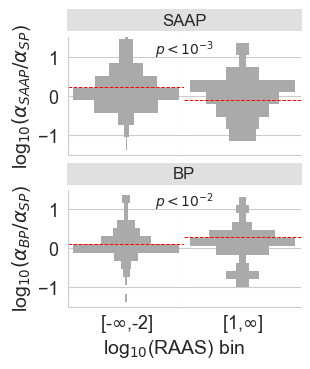

In [55]:
import matplotlib.patches as patches

# plot distributions of abundance of SAAP/BP to shared peptide abundance as a function of RAAS 
# ONLY EXTREME BINS

raas_bins_2plot = ['[-$\infty$,-2]', '[1,$\infty$]']

fig,axi = plt.subplots(2, 2, figsize=(3,3.5), sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.3)
sns.set_style('whitegrid')
for j, axes in enumerate(axi):
    for i,rbin in enumerate(raas_bins_2plot):
        ax = axes[i]
        if j==1:
            ax.set_xlabel(rbin, fontsize=13);
        ax.set_xticks([])
        if j==0:
            rbin_data = [np.log10(x) for x in plot_df.loc[plot_df['RAAS_bin']==rbin, 'SAAP_shared_ratio'].values]
            peptype = 'SAAP'
        else:
            rbin_data = [np.log10(x) for x in plot_df.loc[plot_df['RAAS_bin']==rbin, 'BP_shared_ratio'].values]
            peptype = 'BP'

        rbin_data = [x for x in rbin_data if (~np.isnan(x)) and (~np.isinf(x))]
        print('% out of range: '+str(len([x for x in rbin_data if np.abs(x)>1.5])/len(rbin_data)))
        bihist(rbin_data, rbin_data, nbins=20, h=ax)
        if i>0:
            ax.spines['left'].set_visible(False)
           # ax.set_yticks([])
        ax.spines['top'].set_visible(False)

        median_abund = np.nanmean(rbin_data)
        print(rbin, median_abund)
        ax.plot(ax.get_xlim(), (median_abund, median_abund), '--r', linewidth=0.7)

        if ax==axes[-1]:
            ax.spines['right'].set_visible(False)
        ax.set_ylim([-4.5,4])

    axes[0].tick_params('y', labelsize=13)
   # axes[0].set_yticks([-4,-2,0,2,4], labels=[-4,-2,0,2,'']);


    # Define the box boundaries in figure coordinates
    # These values need to be adjusted based on your specific figure layout
    box_x = 0.12  # Starting x-coordinate (normalized figure units)
    box_y = 0.9  # Starting y-coordinate (normalized figure units)
    box_width = 0.78 # Width of the box (normalized figure units)
    box_height = 0.06 # Height of the box (normalized figure units)
    # Create a Rectangle patch in figure coordinates
    rect1 = patches.Rectangle((box_x, box_y), box_width, box_height,
                            linewidth=0.7,  edgecolor='#e0e0e0', facecolor='#e0e0e0',
                            transform=fig.transFigure, zorder=-1) # zorder to put behind axes
    # Add the patch to the figure
    fig.add_artist(rect1)

   # Define the box boundaries in figure coordinates
    # These values need to be adjusted based on your specific figure layout
    box_x = 0.12  # Starting x-coordinate (normalized figure units)
    box_y = 0.46  # Starting y-coordinate (normalized figure units)
    box_width = 0.78 # Width of the box (normalized figure units)
    box_height = 0.06 # Height of the box (normalized figure units)
    # Create a Rectangle patch in figure coordinates
    rect2 = patches.Rectangle((box_x, box_y), box_width, box_height,
                            linewidth=0.7, edgecolor='#e0e0e0', facecolor='#e0e0e0',
                            transform=fig.transFigure, zorder=-1) # zorder to put behind axes
    # Add the patch to the figure
    fig.add_artist(rect2)

    axes[1].annotate(peptype, (0, 1.1), xycoords='axes fraction', ha='center', fontsize=12)#, bbox=dict(boxstyle="square,pad=0.3", fc="#d0d0d0", ec="k", lw=0.7))   
axi[0][0].annotate(r'log$_{10}(\alpha_{SAAP}/\alpha_{SP}$)', (-0.4,0.5), xycoords='axes fraction', fontsize=14, rotation='vertical', va='center', ha='center')
axi[1][0].annotate(r'log$_{10}(\alpha_{BP}/\alpha_{SP}$)', (-0.4,0.5), xycoords='axes fraction', fontsize=14, rotation='vertical', va='center', ha='center')
axi[1][0].annotate('log$_{10}$(RAAS) bin', (0.3, -0.35), xycoords='axes fraction', fontsize=14, va='center', ha='left')

p_saap = sp.stats.ttest_ind([np.log10(x) for x in plot_df.loc[plot_df['RAAS_bin']=='[-$\infty$,-2]', 'SAAP_shared_ratio'].values], [np.log10(x) for x in plot_df.loc[plot_df['RAAS_bin']=='[1,$\infty$]', 'SAAP_shared_ratio'].values])[1]
p_bp = sp.stats.ttest_ind([np.log10(x) for x in plot_df.loc[plot_df['RAAS_bin']=='[-$\infty$,-2]', 'BP_shared_ratio'].values], [np.log10(x) for x in plot_df.loc[plot_df['RAAS_bin']=='[1,$\infty$]', 'BP_shared_ratio'].values])[1]
print(p_saap, p_bp)
axi[0][1].annotate(r'$p<10^{-3}$', (0,0.9), xycoords='axes fraction', fontsize=10, rotation='horizontal', va='center', ha='center')
axi[1][1].annotate(r'$p<10^{-2}$', (0,0.9), xycoords='axes fraction', fontsize=10, rotation='horizontal', va='center', ha='center')

#plt.suptitle('Degradation rate ratios', fontsize=14)  
plt.ylim([-1.5,1.5])


plt.savefig(outdir+'SAAP_BP_SP_turnover_ratio_bihist_RAASbins_extreme.pdf', bbox_inches='tight')    
plt.savefig(outdir+'SAAP_BP_SP_turnover_ratio_bihist_RAASbins_extreme.png', dpi=300, bbox_inches='tight')    


### Figure 3b and Extended Data Figure 3k: RAAS vs. codon usage metrics

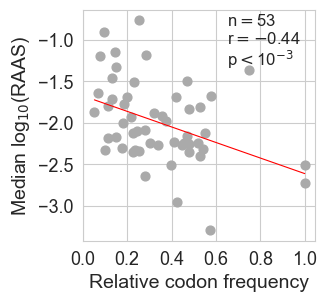

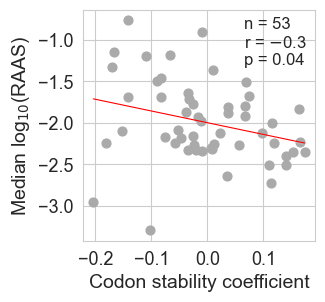

In [64]:
codon_freq = pd.read_table(dependencies_dir+'codon_frequencies.txt')


sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.regplot(data=codon_freq, y='RAAS', x='frequency_all', color='#AAAAAA', ci=False, 
            line_kws={'color':'r', 'linewidth':0.8}, scatter_kws={'s':40, 'alpha':1})
ax.tick_params('both', labelsize=13)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Relative codon frequency', fontsize=14)
plt.xticks([0,0.2,0.4,0.6,0.8,1]);

# values were computed with sp.stats.pearson and then annotated manually
codon_freq_nonan = codon_freq.dropna(how='any')
r,p = sp.stats.pearsonr(codon_freq_nonan['RAAS'].values, codon_freq_nonan['frequency_all'].values)
ax.text(0.65,-0.83, r'n$=$53', fontsize=12)
ax.text(0.65,-1.05, r'r$=$$-$0.44', fontsize=12)
ax.text(0.65,-1.3, r'p$<$10$^{-3}$', fontsize=12)

plt.savefig(outdir+'codon_frequencies.pdf', bbox_inches='tight')



sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.regplot(data=codon_freq, y='RAAS', x='293T_endo', color='#AAAAAA', ci=False, 
            line_kws={'color':'r', 'linewidth':0.8}, scatter_kws={'s':40, 'alpha':1})
ax.tick_params('both', labelsize=13)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Codon stability coefficient', fontsize=14)
plt.xticks([-0.2,-0.1,0,0.1]);

# values were computed with sp.stats.pearson and then annotated manually
r,p = sp.stats.pearsonr(codon_freq_nonan['RAAS'].values, codon_freq_nonan['293T_endo'].values)
ax.text(0.065,-0.87, r'n = 53', fontsize=12)
ax.text(0.065,-1.1, r'r = $-$0.3', fontsize=12)
ax.text(0.065,-1.3, r'p = 0.04', fontsize=12)


plt.savefig(outdir+'codon_stabilities.pdf', bbox_inches='tight')

### Supplemental Figure 6: PepQuery

In [76]:
# read in the results from running PepQuery on SAAP from LUAD and LSCC
# save whether or not each SAAP was matched to spectra by PepQuery
pepquery_dir = dependencies_dir+'PepQuery/'

all_ds_saap_dict = {}
ds = 'CCRCC'
for ds in ['LSCC', 'LUAD']:
    print(ds)
    ds_pepquery_dir = pepquery_dir+ds+'_saap/'
    ds_results = pd.read_table(ds_pepquery_dir+'/psm_rank.txt')
    seqs = open(pepquery_dir+ds+'_pepquery_seqs.txt', 'r').readlines()
    print(len(seqs))

    seq_dict = {}
    for seq in seqs:
        seq = seq.split('\n')[0]
        seq_results = ds_results.loc[ds_results['peptide']==seq]
        conf_results = seq_results.loc[seq_results['confident']=='Yes']
        if len(conf_results)>0:
            seq_dict[seq] = conf_results.index.to_list()
        else:
            seq_dict[seq] = 'No match'

    print(len([i for i,x in seq_dict.items() if isinstance(x,list)]))
    all_ds_saap_dict[ds] = seq_dict

LSCC
713
518
LUAD
877
730


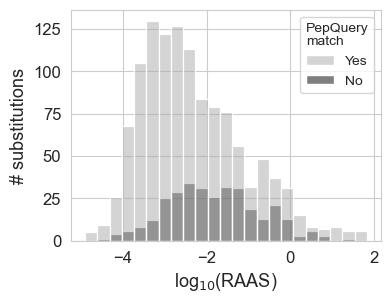

In [66]:
# plot the RAAS distributions for SAAP identified and not matched by PepQuery

plot_rows = []
plot_cols = ['Dataset', 'SAAP', 'RAAS', 'Match']

for ds in all_ds_saap_dict:
    ds_saap_df = filt_saap_df.loc[filt_saap_df['Dataset']==ds]
    for k,v in all_ds_saap_dict[ds].items():
        saap_df = ds_saap_df.loc[ds_saap_df['SAAP']==k]
        raas = saap_df['Mean precursor RAAS'].values[0]
        if v=='No match':
            plot_rows.append([ds, k, raas, 'No'])
        else:
            plot_rows.append([ds, k, raas, 'Yes'])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)


fig,ax = plt.subplots(figsize=(4,3))
s = sns.histplot(data=plot_df, x='RAAS', hue='Match', palette=sns.set_palette(['#AAAAAA', 'black']))
plt.xlabel('log$_{10}$(RAAS)', fontsize=13)

legend = s.get_legend()
legend.set_title('PepQuery\nmatch')
#plt.yscale('log')
plt.ylabel('# substitutions', fontsize=13)
ax.tick_params('both', labelsize=12)

plt.savefig(outdir+'PepQuery_ID_vs_RAAS.png', dpi=300, bbox_inches='tight')
plt.savefig(outdir+'PepQuery_ID_vs_RAAS.pdf',bbox_inches='tight')

In [68]:
# read in the results from running PepQuery on BP from LUAD and LSCC
# save whether or not each BP was matched to spectra by PepQuery

all_ds_bp_dict = {}
ds = 'CCRCC'
for ds in ['LSCC', 'LUAD']:

    print(ds)
    ds_pepquery_dir = pepquery_dir +ds+'_bp/'
    ds_results = pd.read_table(ds_pepquery_dir+'/psm_rank.txt')
    seqs = open(pepquery_dir+ds+'_pepquery_bp_seqs.txt', 'r').readlines()
    print(len(seqs))

    seq_dict = {}
    for seq in seqs:
        seq = seq.split('\n')[0]
        seq_results = ds_results.loc[ds_results['peptide']==seq]
        conf_results = seq_results.loc[seq_results['confident']=='Yes']
        if len(conf_results)>0:
            seq_dict[seq] = conf_results.index.to_list()
        else:
            seq_dict[seq] = 'No match'

    print(len([i for i,x in seq_dict.items() if isinstance(x,list)]))
    all_ds_bp_dict[ds] = seq_dict

LSCC
713
486
LUAD
877
529


In [69]:
# read in the results from running PepQuery on reversed SAAP from LUAD and LSCC
# save whether or not each sequence was matched to spectra by PepQuery


all_ds_rev_dict = {}
for ds in ['LSCC', 'LUAD']:
    seqs = open(pepquery_dir+ds+'_PepQuery_scrambled_seqs.txt', 'r').readlines()
    #nseqs = len(seqs)
    ds_pepquery_dir =pepquery_dir +ds+'_rev/'
    ds_results = pd.read_table(ds_pepquery_dir+'/psm_rank.txt')
    

    seq_dict = {}
    for seq in seqs:
        seq = seq.split('\n')[0]
        seq_results = ds_results.loc[ds_results['peptide']==seq]
        conf_results = seq_results.loc[seq_results['confident']=='Yes']
        if len(conf_results)>0:
            seq_dict[seq] = conf_results.index.to_list()
        else:
            seq_dict[seq] = 'No match'

    print(len([i for i,x in seq_dict.items() if isinstance(x,list)]))
    all_ds_rev_dict[ds] = seq_dict

3
18


In [77]:
pcnt_bar_rows = []
pcnt_bar_cols = ['Peptide', '# peptides', 'Dataset']

for ds in ['LSCC', 'LUAD']:
    print(ds)
    seqs = open(pepquery_dir+ds+'_pepquery_bp_seqs.txt', 'r').readlines()
    nseqs = len(seqs)
    n_saap = len([i for i,x in all_ds_saap_dict[ds].items() if isinstance(x,list)])
    print(n_saap/nseqs)
    n_bp = len([i for i,x in all_ds_bp_dict[ds].items() if isinstance(x,list)])
    print(n_bp/nseqs)
    n_rev = len([i for i,x in all_ds_rev_dict[ds].items() if isinstance(x,list)])
    print(n_rev/nseqs)

    pcnt_bar_rows.append(['Confident rev', 100*n_rev/nseqs, ds])
    pcnt_bar_rows.append(['Confident SAAP', 100*n_saap/nseqs, ds])
    pcnt_bar_rows.append(['Confident BP', 100*n_bp/nseqs, ds])

pcnt_bar_df = pd.DataFrame(pcnt_bar_rows, columns=pcnt_bar_cols)



LSCC
0.726507713884993
0.6816269284712483
0.004207573632538569
LUAD
0.8323831242873432
0.6031927023945268
0.020524515393386546


/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_59055/2153884048.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data=pcnt_bar_df, x='Dataset', y='# peptides', hue='Peptide', palette=colors)


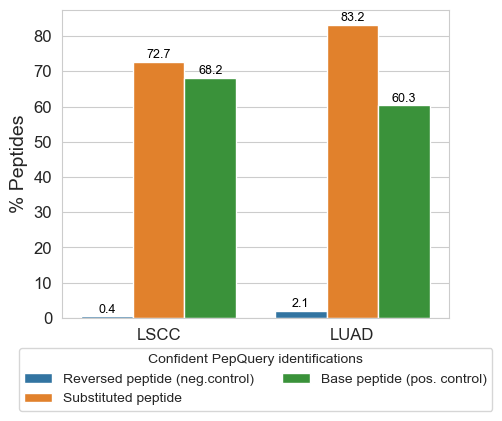

In [79]:
# plot percent of SAAP, BP and reversed SAAP that were matched by PepQuery

sns.set_style('whitegrid')

fig,ax = plt.subplots(figsize=(5,4))
sns.barplot(data=pcnt_bar_df, x='Dataset', y='# peptides', hue='Peptide', palette=colors)

ax.tick_params('both', labelsize=12)
plt.ylabel('% Peptides', fontsize=14)
plt.xlabel('')
handles,labels = ax.get_legend_handles_labels()
plt.legend(title='Confident PepQuery identifications', handles=handles, labels=['Reversed peptide (neg.control)', 'Substituted peptide', 'Base peptide (pos. control)'], 
           bbox_to_anchor=(0.5,-0.2), loc='center',ncol=2)

for p in ax.patches:
    height = p.get_height()
    if height!=0:
        ax.annotate(
            '{:.1f}'.format(height), # Format as integer
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 0.5), # 5 points vertical offset
            textcoords="offset points",
            ha='center',
            va='bottom',
            color='black',
            fontsize=9
        )
#plt.show()
#plt.yscale('log')
plt.savefig(outdir+'PepQuery_pcnt_peptides_confident.pdf', bbox_inches='tight')
plt.savefig(outdir+'PepQuery_pcnt_peptides_confident.png',dpi=300, bbox_inches='tight')